In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [3]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

1.15.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [4]:
mu0 = 0
sigma0 = 1

eff = 0.001 #fraction of true but not reco
fake = 0.001 #fraction of reco but not true

In [5]:
N = 10**5
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G))
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N)
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) 
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

/Users/bpnachman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


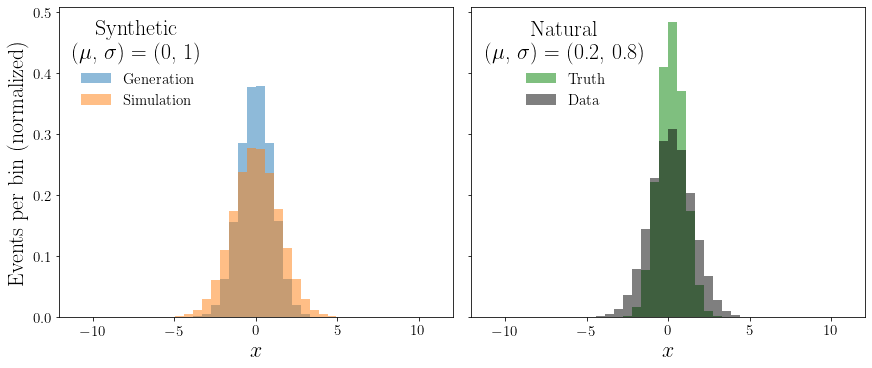

In [6]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [7]:
iterations = 10

In [8]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [10]:
# initial iterative weights are ones

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [11]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights_pull[theta0_S==dummyval] = 1. #these are events that don't pass reco; take the prior.
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=2000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 149844 samples, validate on 49955 samples
Epoch 1/200
149844/149844 [==============================] - 1s 8us/step - loss: 0.6901 - accuracy: 0.5283 - val_loss: 0.6883 - val_accuracy: 0.5364
Epoch 2/200
149844/149844 [==============================] - 0s 2us/step - loss: 0.6889 - accuracy: 0.5329 - val_loss: 0.6877 - val_accuracy: 0.5376
Epoch 3/200
149844/149844 [==============================] - 0s 2us/step - loss: 0.6887 - accuracy: 0.5329 - val_loss: 0.6877 - val_accuracy: 0.5395
Epoch 4/200
149844/149844 [==============================] - 0s 2us/step - loss: 0.6887 - accuracy: 0.5334 - val_loss: 0.6876 - val_accuracy: 0.5395
Epoch 5/200
149844/149844 [==============================] - 0s 2us/step - loss: 0.6887 - accuracy: 0.5338 - val_loss: 0.6876 - val_accuracy: 0.5389
Epoch 6/200
149844/149844 [==============================] - 0s 2us/step - loss: 0.688

Epoch 32/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6894 - accuracy: 0.4996 - val_loss: 0.6890 - val_accuracy: 0.5013
Epoch 33/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6894 - accuracy: 0.4994 - val_loss: 0.6889 - val_accuracy: 0.5015
Epoch 34/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6894 - accuracy: 0.4996 - val_loss: 0.6889 - val_accuracy: 0.5012
Restoring model weights from the end of the best epoch
Epoch 00034: early stopping

ITERATION: 2

STEP 1

Train on 149848 samples, validate on 49951 samples
Epoch 1/200
149848/149848 [==============================] - 1s 8us/step - loss: 0.6867 - accuracy: 0.5331 - val_loss: 0.6862 - val_accuracy: 0.5352
Epoch 2/200
149848/149848 [==============================] - 0s 2us/step - loss: 0.6865 - accuracy: 0.5329 - val_loss: 0.6861 - val_accuracy: 0.5356
Epoch 3/200
149848/149848 [==============================] - 0s 2us/step - loss: 0.6865 - accur

Epoch 19/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6884 - accuracy: 0.5013 - val_loss: 0.6891 - val_accuracy: 0.4954
Restoring model weights from the end of the best epoch
Epoch 00019: early stopping

ITERATION: 3

STEP 1

Train on 149847 samples, validate on 49952 samples
Epoch 1/200
149847/149847 [==============================] - 1s 9us/step - loss: 0.6931 - accuracy: 0.5336 - val_loss: 0.6921 - val_accuracy: 0.5323
Epoch 2/200
149847/149847 [==============================] - 0s 2us/step - loss: 0.6921 - accuracy: 0.5313 - val_loss: 0.6919 - val_accuracy: 0.5315
Epoch 3/200
149847/149847 [==============================] - 0s 2us/step - loss: 0.6920 - accuracy: 0.5322 - val_loss: 0.6918 - val_accuracy: 0.5336
Epoch 4/200
149847/149847 [==============================] - 0s 2us/step - loss: 0.6919 - accuracy: 0.5324 - val_loss: 0.6918 - val_accuracy: 0.5327
Epoch 5/200
149847/149847 [==============================] - 0s 2us/step - loss: 0.6919 - accurac

Epoch 5/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6848 - accuracy: 0.5010 - val_loss: 0.6849 - val_accuracy: 0.4972
Epoch 6/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6849 - accuracy: 0.5008 - val_loss: 0.6849 - val_accuracy: 0.4990
Epoch 7/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6848 - accuracy: 0.5007 - val_loss: 0.6848 - val_accuracy: 0.4979
Epoch 8/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6848 - accuracy: 0.5006 - val_loss: 0.6849 - val_accuracy: 0.4987
Epoch 9/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6848 - accuracy: 0.5000 - val_loss: 0.6849 - val_accuracy: 0.4978
Epoch 10/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6848 - accuracy: 0.5008 - val_loss: 0.6849 - val_accuracy: 0.4979
Epoch 11/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6848 - accuracy: 0.50

Epoch 21/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6846 - accuracy: 0.5001 - val_loss: 0.6847 - val_accuracy: 0.5001
Epoch 22/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6846 - accuracy: 0.4995 - val_loss: 0.6847 - val_accuracy: 0.5001
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

ITERATION: 6

STEP 1

Train on 149851 samples, validate on 49948 samples
Epoch 1/200
149851/149851 [==============================] - 2s 10us/step - loss: 0.7020 - accuracy: 0.5330 - val_loss: 0.6970 - val_accuracy: 0.5294
Epoch 2/200
149851/149851 [==============================] - 0s 2us/step - loss: 0.6949 - accuracy: 0.5252 - val_loss: 0.6949 - val_accuracy: 0.5188
Epoch 3/200
149851/149851 [==============================] - 0s 2us/step - loss: 0.6937 - accuracy: 0.5204 - val_loss: 0.6941 - val_accuracy: 0.5194
Epoch 4/200
149851/149851 [==============================] - 0s 2us/step - loss: 0.6933 - accur

Epoch 22/200
149840/149840 [==============================] - 0s 2us/step - loss: 0.6930 - accuracy: 0.5225 - val_loss: 0.6934 - val_accuracy: 0.5182
Epoch 23/200
149840/149840 [==============================] - 0s 2us/step - loss: 0.6930 - accuracy: 0.5244 - val_loss: 0.6934 - val_accuracy: 0.5209
Epoch 24/200
149840/149840 [==============================] - 0s 2us/step - loss: 0.6930 - accuracy: 0.5198 - val_loss: 0.6934 - val_accuracy: 0.5158
Epoch 25/200
149840/149840 [==============================] - 0s 2us/step - loss: 0.6930 - accuracy: 0.5226 - val_loss: 0.6934 - val_accuracy: 0.5276
Epoch 26/200
149840/149840 [==============================] - 0s 2us/step - loss: 0.6930 - accuracy: 0.5265 - val_loss: 0.6934 - val_accuracy: 0.5181
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping

STEP 2

Train on 150000 samples, validate on 50000 samples
Epoch 1/200
150000/150000 [==============================] - 2s 15us/step - loss: 0.6837 - accuracy: 0.4997

Epoch 13/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6813 - accuracy: 0.4994 - val_loss: 0.6807 - val_accuracy: 0.5018
Epoch 14/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6813 - accuracy: 0.4996 - val_loss: 0.6809 - val_accuracy: 0.5016
Epoch 15/200
150000/150000 [==============================] - 1s 6us/step - loss: 0.6813 - accuracy: 0.4997 - val_loss: 0.6808 - val_accuracy: 0.5009
Epoch 16/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6813 - accuracy: 0.4997 - val_loss: 0.6808 - val_accuracy: 0.5011
Epoch 17/200
150000/150000 [==============================] - 1s 5us/step - loss: 0.6813 - accuracy: 0.4995 - val_loss: 0.6807 - val_accuracy: 0.5011
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping

ITERATION: 9

STEP 1

Train on 149850 samples, validate on 49949 samples
Epoch 1/200
149850/149850 [==============================] - 2s 12us/step - loss: 0.7079 - ac

Epoch 11/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6797 - accuracy: 0.5012 - val_loss: 0.6802 - val_accuracy: 0.4978
Epoch 12/200
150000/150000 [==============================] - 1s 4us/step - loss: 0.6797 - accuracy: 0.5011 - val_loss: 0.6802 - val_accuracy: 0.4979
Restoring model weights from the end of the best epoch
Epoch 00012: early stopping

ITERATION: 10

STEP 1

Train on 149843 samples, validate on 49956 samples
Epoch 1/200
149843/149843 [==============================] - 2s 12us/step - loss: 0.7050 - accuracy: 0.5321 - val_loss: 0.6991 - val_accuracy: 0.5280
Epoch 2/200
149843/149843 [==============================] - 0s 2us/step - loss: 0.6951 - accuracy: 0.5248 - val_loss: 0.6960 - val_accuracy: 0.5156
Epoch 3/200
149843/149843 [==============================] - 0s 2us/step - loss: 0.6936 - accuracy: 0.5184 - val_loss: 0.6950 - val_accuracy: 0.5192
Epoch 4/200
149843/149843 [==============================] - 0s 2us/step - loss: 0.6929 - accu

INITIAL 10:


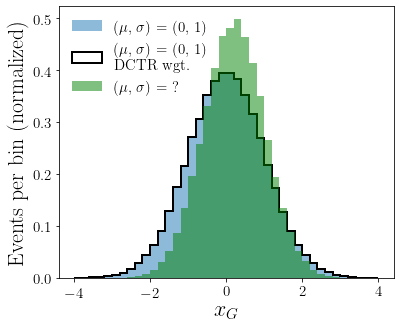

ITERATION 1:


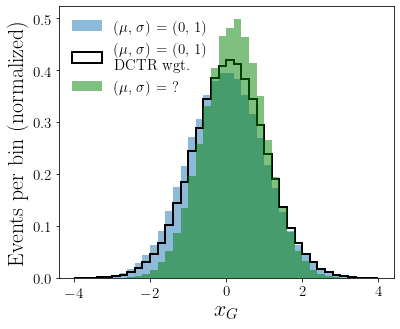

ITERATION 2:


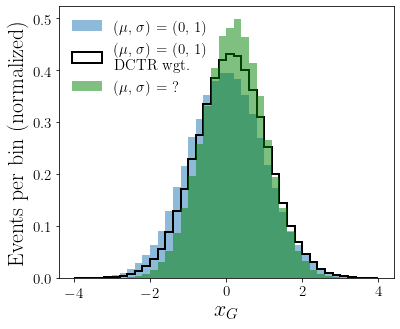

ITERATION 3:


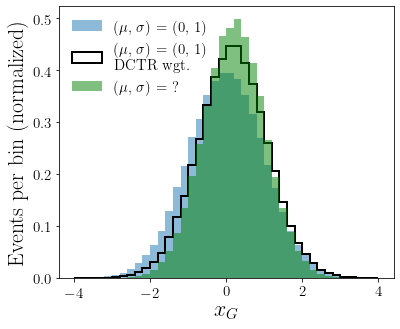

ITERATION 4:


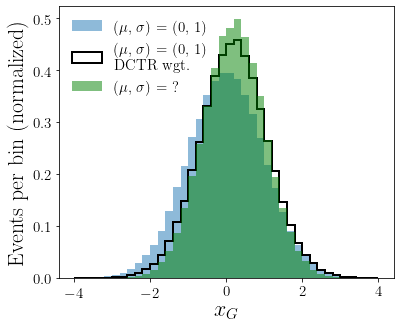

ITERATION 5:


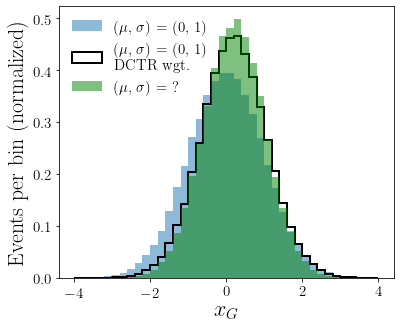

ITERATION 6:


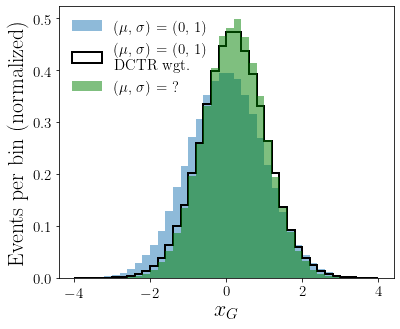

ITERATION 7:


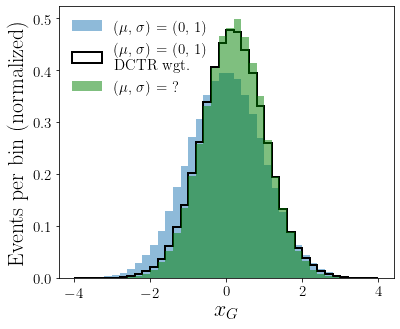

ITERATION 8:


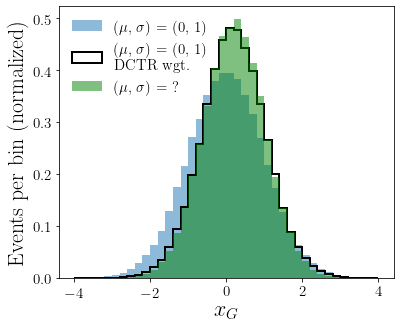

ITERATION 9:


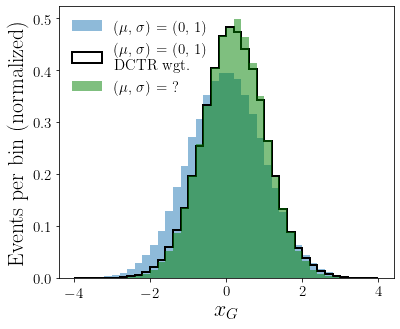

ITERATION 10:


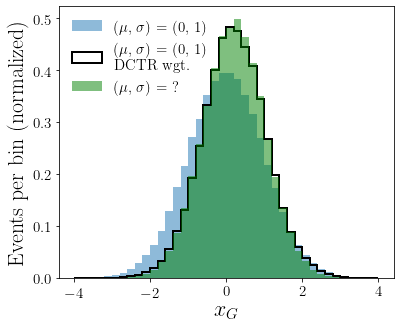

In [12]:
bins = np.linspace(-4, 4, 41)

print("INITIAL {}:".format(i + 1))
plt.figure(figsize=(6, 5))
hist0 = plt.hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

hist1 = plt.hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
hist2 = plt.hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
plt.legend(frameon=False)
plt.xlabel(r"$x_G$")
plt.ylabel("Events per bin (normalized)")
plt.show()

for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    plt.legend(frameon=False)
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()